# UTC, UT1 and `astropy`


### What's the difference between UTC and UT1? 

Keeping time is a messy business. Depending on your perspective, you may want one of two (or more) time systems: 

1. As humans, we want a time system that ticks in seconds on the surface of the Earth contiguously and forever, both backwards and forwards in time.
2. As astronomers, we want a time system that will place stationary astronomical objects (like distant quasars) at the same position in the sky with predictable periodicity. 

It turns out that reconciling these distinct systems is a difficult task because the [Earth's rotation period is constantly changing](https://en.wikipedia.org/wiki/Earth's_rotation#Changes_in_rotation) due to tidal forces and changes in the Earth's moment of inertia. As a result, the number of seconds in a mean solar day or year changes with time in ways that are (at present) impossible to predict, since the variations depend on plate tectonics, large-scale weather patterns, earthquakes, and other stochastic events. 

The solution is to keep these two time systems independent.

### Coordinated Universial Time (UTC)

The first time system is kept by atomic clocks which tick with no regard for the Earth's rotation. If that system was left uncorrected over many years, solar noon would no longer occur at noon on the atomic clocks, because 24 hours $\times$ 60 minutes $\times$ 60 seconds is not *precisely* the rotation period of the Earth. To make up for this, the atomic clock timekeeping system gets [leap seconds](https://en.wikipedia.org/wiki/Leap_second) added to it every so often to keep the atomic clock time as close as possible (within 0.9 seconds) to mean solar time. We call this [Coordinated Universial Time (UTC)](https://en.wikipedia.org/wiki/Coordinated_Universal_Time). 

### Universal Time 1 (UT1)

The second time system is kept by very precisely, for example, by measuring the positions of distant quasars using [Very Long Baseline Interferometry](https://en.wikipedia.org/wiki/Very-long-baseline_interferometry). This time is therefore defined by the rotation of the Earth, and varies with respect to UTC as the Earth's rotation period changes. The orientation of the Earth, which must be measured continuously to keep UT1 accurate, is logged by the International Earth Rotation and Reference Systems Service (IERS). They update a "bulletin" with the most recent measurements of the Earth's orientation, called [Bulletin B](http://www.iers.org/IERS/EN/DataProducts/EarthOrientationData/eop.html), referred to within `astropy` as the IERS B table. Bulletin A has predictions for the next 10 years into the future.

### Converting between UTC and UT1

The difference between UTC and UT1 are therefore modulated by (1) changes in the Earth's rotation period and (2) leap seconds introduced to try to keep the two conventions as close to each other as possible. To compute the difference between the two is simple with `astropy`, and reveals the strange history of our dynamic time system.

### Exploring the history of differences between UT1 and UTC

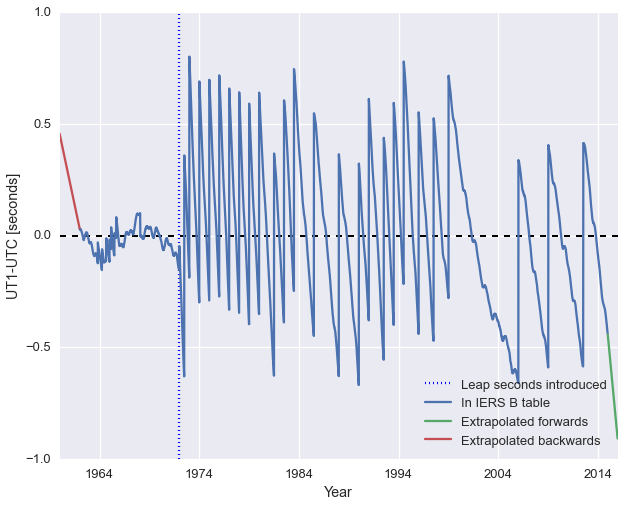

In [4]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Make the plots pretty
import seaborn as sns
sns.set(context='talk')

# Generate a range of times from 1960 (before leap seconds)
# to near the present day
dt_range = np.array([datetime.datetime(1960, 1, 1) + 
                     i*datetime.timedelta(days=3.65) for 
                     i in range(5600)])
# Convert to astropy time object
from astropy.time import Time
time_range = Time(dt_range)

# Calculate the difference between UTC and UT1 at those times,
# allowing times "outside of the table"
DUT1, success = time_range.get_delta_ut1_utc(return_status=True)

# Compare input times to the times available in the table. See
# https://github.com/astropy/astropy/blob/master/astropy/utils/iers/iers.py#L80
from astropy.utils.iers import (TIME_BEFORE_IERS_RANGE, TIME_BEYOND_IERS_RANGE,
                                FROM_IERS_A, FROM_IERS_B)
extrapolated_beyond_table = success == TIME_BEYOND_IERS_RANGE
extrapolated_before_table = success == TIME_BEFORE_IERS_RANGE
in_table = success == FROM_IERS_B

# Make a plot of the time difference
fig, ax = plt.subplots(figsize=(10,8))
ax.axhline(0, color='k', ls='--', lw=2)

ax.axvline(datetime.datetime(1972,1,1), ls=':',
           label='Leap seconds introduced')

ax.plot_date(dt_range[in_table], DUT1[in_table], '-',
             label='In IERS B table')
ax.plot_date(dt_range[extrapolated_beyond_table], 
             DUT1[extrapolated_beyond_table], '-',
             label='Extrapolated forwards')
ax.plot_date(dt_range[extrapolated_before_table], 
             DUT1[extrapolated_before_table], '-',
             label='Extrapolated backwards')

ax.set(xlabel='Year', ylabel='UT1-UTC [seconds]')
ax.legend(loc='lower right')
fig.savefig('plots/DUT1.png', bbox_inches='tight')
plt.show()

The default IERS B table will have precise times between ~1964-2014, and will extrapolate off the ends of the table. For predictions for the future, the IERS A table will be more accurate by knowing about upcoming leap seconds: 

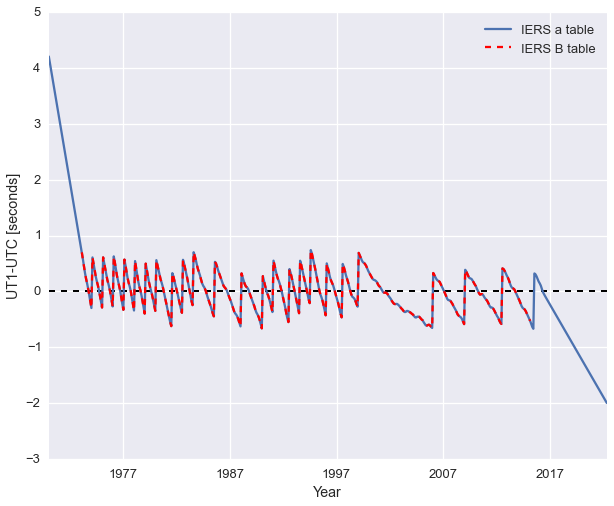

In [3]:
# Download and cache the IERS A and B tables
from astropy.utils.iers import IERS_A, IERS_A_URL, IERS_B, IERS_B_URL
from astropy.utils.data import download_file
iers_a_file = download_file(IERS_A_URL, cache=True)
iers_a = IERS_A.open(iers_a_file)
iers_b_file = download_file(IERS_A_URL, cache=True)
iers_b = IERS_A.open(iers_b_file)

# Generate a range of times from 1960 (before leap seconds)
# to near the present day
dt_range = np.array([datetime.datetime(1970, 1, 1) + 
                     i*datetime.timedelta(days=36.5) for 
                     i in range(525)])
# Convert to astropy time object
from astropy.time import Time
time_range = Time(dt_range)

# Calculate the difference between UTC and UT1 at those times,
# allowing times "outside of the table"
DUT1_a, success_a = time_range.get_delta_ut1_utc(return_status=True, iers_table=iers_a)
DUT1_b, success_b = time_range.get_delta_ut1_utc(return_status=True, iers_table=iers_b)

# Compare input times to the times available in the table. See
# https://github.com/astropy/astropy/blob/master/astropy/utils/iers/iers.py#L80
from astropy.utils.iers import (TIME_BEFORE_IERS_RANGE, TIME_BEYOND_IERS_RANGE,
                                FROM_IERS_A, FROM_IERS_B, FROM_IERS_A_PREDICTION)

in_table_b = success_b == FROM_IERS_B

# Make a plot of the time difference
fig, ax = plt.subplots(figsize=(10,8))
ax.axhline(0, color='k', ls='--', lw=2)

ax.plot_date(dt_range, DUT1_a, '-',
             label='IERS a table')
ax.plot_date(dt_range[in_table_b], DUT1_b[in_table_b], 'r--',
             label='IERS B table')

ax.set(xlabel='Year', ylabel='UT1-UTC [seconds]')
ax.legend(loc='upper right')
fig.savefig('plots/DUT1ab.png', bbox_inches='tight')
plt.show()